In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
conn = sqlite3.connect('database.sqlite')
tweets_df = pd.read_sql_query("SELECT * FROM Tweets;", conn)
conn.close()

In [2]:
tweets_df.head(20)
print(f"# of rows: {tweets_df.shape[0]}")
print(f"# of columns: {tweets_df.shape[1]}")
print('\n')
print('Columns:')
for i in tweets_df.columns:
    print('- ',i)

# of rows: 14485
# of columns: 15


Columns:
-  tweet_id
-  airline_sentiment
-  airline_sentiment_confidence
-  negativereason
-  negativereason_confidence
-  airline
-  airline_sentiment_gold
-  name
-  negativereason_gold
-  retweet_count
-  text
-  tweet_coord
-  tweet_created
-  tweet_location
-  user_timezone


In [3]:
tweets_df.isnull().sum()

tweet_id                        0
airline_sentiment               0
airline_sentiment_confidence    0
negativereason                  0
negativereason_confidence       0
airline                         0
airline_sentiment_gold          0
name                            0
negativereason_gold             0
retweet_count                   0
text                            0
tweet_coord                     0
tweet_created                   0
tweet_location                  0
user_timezone                   0
dtype: int64

In [4]:
df_columns = list(tweets_df.columns)

In [5]:
print(f"# of unique coordinate: {tweets_df['tweet_coord'].nunique()}")
print(f"# of unique locations: {tweets_df['tweet_location'].nunique()}")
print('\n')
print('Locations:')
unique_locations = [i for i in tweets_df['tweet_location'].sort_values().unique()]
print(f"First entry: {unique_locations[0]}\nLast entry: {unique_locations[-1]}")
print('\n')
print('Coordinates:')
unique_coords = [i for i in tweets_df['tweet_coord'].sort_values().unique()]
print(f"First entry: {unique_coords[0]}\nLast entry: {unique_coords[-1]}")

# of unique coordinate: 833
# of unique locations: 3082


Locations:
First entry: 
Last entry: 명동서식 37.56638,126.984994


Coordinates:
First entry: 
Last entry: [59.38247253, 18.00789007]


In [6]:
print(f"Number of blank coordinates: {tweets_df['tweet_coord'][tweets_df['tweet_coord']==''].shape[0]}") 

Number of blank coordinates: 13478


In [7]:
print(f"Number of blank locations: {tweets_df['tweet_location'][tweets_df['tweet_location']==''].shape[0]}") 

Number of blank locations: 4687


In [8]:
import re
# Function to detect non-standard locations (containing emojis, special characters, or blank spaces)
def is_non_standard_location(location):
    if pd.isnull(location) or location.strip() == '':
        return True
    # Regex pattern to detect emojis and special characters
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        ']+', 
        flags=re.UNICODE
    )
    if emoji_pattern.search(location):
        return True
    # Check for other non-standard characters (example: symbols)
    special_char_pattern = re.compile(r'[^a-zA-Z0-9\s,]')
    if special_char_pattern.search(location):
        return True
    return False

# Apply the function to replace non-standard locations with 'Unknown'
tweets_df['tweet_location'] = tweets_df['tweet_location'].apply(
    lambda x: 'Unknown' if is_non_standard_location(x) else x
)

print(f"Actual number of unknown locations: {tweets_df[tweets_df['tweet_location']=='Unknown'].shape[0]}") 

Actual number of unknown locations: 6236


In [9]:
# Function to clean location names by removing double spaces and trimming
def clean_location(location):
    if pd.isnull(location):
        return location
    # Remove extra spaces
    location = re.sub(r'\s+', ' ', location).strip()
    return location

tweets_df['cleaned_temp'] = tweets_df['tweet_location'].apply(clean_location)

# Compare the original and cleaned columns to determine the number of affected rows
affected_rows = (tweets_df['tweet_location'] != tweets_df['cleaned_temp']).sum()

# Update the tweet_location column with cleaned data
tweets_df['tweet_location'] = tweets_df['cleaned_temp']

# Drop the temporary column
tweets_df.drop(columns=['cleaned_temp'], inplace=True)

# Display the number of affected rows
print(f"Number of entries cleaned: {affected_rows}") 

Number of entries cleaned: 403


<a href='https://simplemaps.com/data/world-cities'>Map</a> 

In [10]:
top_50 = tweets_df['tweet_location'][tweets_df['tweet_location']!='Unknown'].value_counts().sort_values(ascending=False).head(50).to_frame().reset_index()
top_50.columns = ['city','occurances']
top_50


,city,occurances
0,"Boston, MA",162
1,"New York, NY",162
2,"Washington, DC",146
3,New York,135
4,USA,127
5,Chicago,104
6,New York City,102
7,NYC,97
8,"Los Angeles, CA",93
9,"San Francisco, CA",92


In [11]:
location_mapping = {
    "New York, NY": "New York City, NY",
    "New York": "New York City, NY",
    "NYC": "New York City, NY",
    "New York City": "New York City, NY",
    "Los Angeles, CA": "Los Angeles, CA",
    "Los Angeles": "Los Angeles, CA",
    "San Francisco, CA": "San Francisco, CA",
    "San Francisco": "San Francisco, CA",
    "Chicago, IL": "Chicago, IL",
    "Chicago": "Chicago, IL",
    "Washington, DC": "Washington, DC",
    "Washington DC": "Washington, DC",
    "Boston, MA": "Boston, MA",
    "Boston": "Boston, MA",
    "Dallas, TX": "Dallas, TX",
    "Dallas, Texas": "Dallas, TX",
    "Austin, TX": "Austin, TX",
    "Brooklyn, NY": "Brooklyn, NY",
    "Brooklyn": "Brooklyn, NY",
    "Nashville, TN": "Nashville, TN",
    "NY": "New York City, NY",
    "Las Vegas, NV": "Las Vegas, NV",
    "Las Vegas": "Las Vegas, NV",
    "USA": "United States",
    "Global": "Worldwide",
    "Logan International Airport": "Boston, MA",
    "New York, New York": "New York City, NY",
    "CT": "Connecticut",
    "DC": "Washington, DC",
    "McKinney TX": "McKinney, TX"
    # Other mappings can be added as needed
}


# Apply the mapping to standardize the tweet_location column
tweets_df['tweet_location'] = tweets_df['tweet_location'].apply(
    lambda x: location_mapping.get(x, x) if x != 'Unknown' else x
)

In [12]:
top_50_updated = tweets_df['tweet_location'][tweets_df['tweet_location']!='Unknown'].value_counts().sort_values(ascending=False).head(50).to_frame().reset_index()
top_50_updated.columns = ['city','occurances']
top_50_updated

,city,occurances
0,"New York City, NY",587
1,"Boston, MA",259
2,"Washington, DC",229
3,"Chicago, IL",189
4,"San Francisco, CA",178
5,"Los Angeles, CA",164
6,United States,139
7,"Brooklyn, NY",90
8,"Dallas, TX",79
9,"Austin, TX",64


In [13]:
top_20 = top_50_updated.head(25)
print(top_20.shape[0])
top_20

25


,city,occurances
0,"New York City, NY",587
1,"Boston, MA",259
2,"Washington, DC",229
3,"Chicago, IL",189
4,"San Francisco, CA",178
5,"Los Angeles, CA",164
6,United States,139
7,"Brooklyn, NY",90
8,"Dallas, TX",79
9,"Austin, TX",64


In [14]:
top_20.drop([12,13,6],inplace=True)
top_20 = top_20.head(20).reset_index(drop=True)
print(top_20.shape[0])
top_20

20


/Users/pablobagano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,city,occurances
0,"New York City, NY",587
1,"Boston, MA",259
2,"Washington, DC",229
3,"Chicago, IL",189
4,"San Francisco, CA",178
5,"Los Angeles, CA",164
6,"Brooklyn, NY",90
7,"Dallas, TX",79
8,"Austin, TX",64
9,"Las Vegas, NV",51


In [15]:
# top_20.to_csv('top_20_final.csv', index=False) 

In [16]:
tweets_df.drop(['tweet_coord','user_timezone'], axis=1, inplace=True)
if 'tweet_coord' not in tweets_df.columns: 
    print('Columns dropped')

Columns dropped


In [17]:
list_of_cities = top_20['city'].unique()
list_of_cities

array(['New York City, NY', 'Boston, MA', 'Washington, DC', 'Chicago, IL',
       'San Francisco, CA', 'Los Angeles, CA', 'Brooklyn, NY',
       'Dallas, TX', 'Austin, TX', 'Las Vegas, NV', 'Nashville, TN',
       'Connecticut', 'Philadelphia, PA', 'San Diego', 'Denver, CO',
       'Houston, TX', 'London', 'Seattle', 'New Jersey', 'Raleigh, NC'],
      dtype=object)

In [18]:
new = [i.split(',') for i in list_of_cities]
new = [i[0] for i in new]
new

['New York City',
 'Boston',
 'Washington',
 'Chicago',
 'San Francisco',
 'Los Angeles',
 'Brooklyn',
 'Dallas',
 'Austin',
 'Las Vegas',
 'Nashville',
 'Connecticut',
 'Philadelphia',
 'San Diego',
 'Denver',
 'Houston',
 'London',
 'Seattle',
 'New Jersey',
 'Raleigh']

In [19]:
top_20['tweet_location'] = new 
top_20['tweet_location'].unique()

array(['New York City', 'Boston', 'Washington', 'Chicago',
       'San Francisco', 'Los Angeles', 'Brooklyn', 'Dallas', 'Austin',
       'Las Vegas', 'Nashville', 'Connecticut', 'Philadelphia',
       'San Diego', 'Denver', 'Houston', 'London', 'Seattle',
       'New Jersey', 'Raleigh'], dtype=object)

In [20]:
top_20_df = tweets_df[tweets_df['tweet_location'].isin([i for i in list_of_cities])]
print(top_20_df.shape[0])
top_20_df

2249


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_created,tweet_location
2,567591480085463040,negative,1.0000,Late Flight,0.346,United,,CPoutloud,,0,@united yes. We waited in line for almost an h...,2015-02-16 23:48:48 -0800,"Washington, DC"
4,567594449874587648,negative,1.0000,Customer Service Issue,0.3451,Southwest,,VahidESQ,,0,@SouthwestAir its cool that my bags take a bit...,2015-02-17 00:00:36 -0800,"Los Angeles, CA"
9,567617486703853568,negative,1.0000,Customer Service Issue,0.6797,United,,feliciastoler,,0,@united I tried 2 DM it would not go thru... n...,2015-02-17 01:32:09 -0800,New Jersey
10,567623209026334720,negative,0.6337,Flight Booking Problems,0.6337,United,,markhlyon,,0,"Wanted to get my bag benefit, but instead get ...",2015-02-17 01:54:53 -0800,"Washington, DC"
21,567676400933416960,negative,1.0000,Late Flight,0.7098,United,,MiKasuga,,0,"@United is officially the worst, most delayed,...",2015-02-17 05:26:15 -0800,"New York City, NY"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14433,570304912468402177,negative,0.6667,Can't Tell,0.3333,United,,andycheco,,0,@united you think you boarded flight AU1066 to...,2015-02-24 11:31:01 -0800,"New York City, NY"
14439,570305264613765122,positive,1.0000,,,American,,jamucsb,,0,@AmericanAir thank you!,2015-02-24 11:32:25 -0800,"Los Angeles, CA"
14448,570306260010176512,negative,1.0000,Flight Booking Problems,0.3488,American,,HollyKinnamon,,0,@AmericanAir 1hr 46 min. Cost of flight change...,2015-02-24 11:36:22 -0800,"Washington, DC"
14449,570306423818723328,neutral,0.6767,,0,American,,sammy575,,0,@AmericanAir is the new 9:45 time confirmed or...,2015-02-24 11:37:01 -0800,"New York City, NY"


In [21]:
top_20['city'].unique()

array(['New York City, NY', 'Boston, MA', 'Washington, DC', 'Chicago, IL',
       'San Francisco, CA', 'Los Angeles, CA', 'Brooklyn, NY',
       'Dallas, TX', 'Austin, TX', 'Las Vegas, NV', 'Nashville, TN',
       'Connecticut', 'Philadelphia, PA', 'San Diego', 'Denver, CO',
       'Houston, TX', 'London', 'Seattle', 'New Jersey', 'Raleigh, NC'],
      dtype=object)

In [22]:
cities_dict = {
    'Washington, DC': 'Washington', 
    'Los Angeles, CA': 'Los Angeles', 
    'New Jersey': 'New Jersey',
    'New York City, NY': 'New York City', 
    'Dallas, TX': 'Dallas', 
    'San Francisco, CA': 'San Francisco',
    'Las Vegas, NV': 'Las Vegas', 
    'Brooklyn, NY': 'New York City', 
    'Nashville, TN': 'Nashville',
    'Boston, MA': 'Boston', 
    'Chicago, IL': 'Chicago', 
    'Austin, TX': 'Austin', 
    'Seattle': 'Seattle',
    'Connecticut': 'Connecticut', 
    'Philadelphia, PA': 'Philadelphia', 
    'Denver, CO': 'Denver', 
    'Raleigh, NC': 'Raleigh', 
    'London': 'London', 
    'San Diego': 'San Diego',
    'Houston, TX': 'Houston'
}

# Assuming top_20_df is your DataFrame loaded from the CSV
top_20_df['tweet_location'] = top_20_df['tweet_location'].map(cities_dict)

# Display the length of the 'tweet_location' column
len(top_20_df['tweet_location'].unique())


/var/folders/pc/2mtk0vbx15j363cqyy9myr0w0000gn/T/ipykernel_14104/4090072208.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_df['tweet_location'] = top_20_df['tweet_location'].map(cities_dict)


19

In [23]:
tweets_df['negativereason'].replace('', 'Unknown', inplace=True)
tweets_df['negativereason'].value_counts()

Unknown                        5403
Customer Service Issue         2885
Late Flight                    1650
Can't Tell                     1176
Cancelled Flight                829
Lost Luggage                    719
Bad Flight                      575
Flight Booking Problems         523
Flight Attendant Complaints     475
longlines                       177
Damaged Luggage                  73
Name: negativereason, dtype: int64

In [24]:
tweets_df[tweets_df['negativereason_confidence']==''].shape[0]

4069

In [25]:
blank_negative = tweets_df[['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence','negativereason', 'negativereason_confidence', 'airline']][tweets_df['negativereason_confidence']=='']
blank_negative['airline_sentiment'].value_counts()

neutral     2062
positive    2007
Name: airline_sentiment, dtype: int64

In [26]:
tweets_df['negativereason_confidence'].replace('',np.nan, inplace=True)
tweets_df['negativereason_confidence'] = tweets_df['negativereason_confidence'].astype('float32')
tweets_df['negativereason_confidence']

0           NaN
1        0.6503
2        0.3460
3        1.0000
4        0.3451
          ...  
14480       NaN
14481       NaN
14482       NaN
14483    1.0000
14484    0.3146
Name: negativereason_confidence, Length: 14485, dtype: float32

The bins for the confidence intervals were chosen to categorize the data into three broad qualitative groups: Low, Medium, and High confidence. Here’s the reasoning behind these specific bins:

**Low Confidence (0 to 0.3):**

Confidence scores in this range indicate a low level of certainty about the negative reason. These scores are generally less reliable and might represent tweets where the sentiment is ambiguous or weakly negative. 

**Medium Confidence (0.3 to 0.7):**

This range captures scores where there is moderate confidence in the identified negative reason. It represents a middle ground where the sentiment is more likely to be accurate but not as strongly confirmed as higher scores. 

**High Confidence (0.7 to 1.0):** 

Scores in this range indicate a high level of certainty. These are the most reliable and likely represent tweets where the negative reason is clearly identified.

In [27]:
bins = [0, 0.3, 0.7, 1.0]
labels = ['Low', 'Medium', 'High']
tweets_df['confidence_level'] = pd.cut(tweets_df['negativereason_confidence'], bins=bins, labels=labels, include_lowest=True)
tweets_df['confidence_level'].value_counts()

Medium    5379
High      3703
Low       1334
Name: confidence_level, dtype: int64

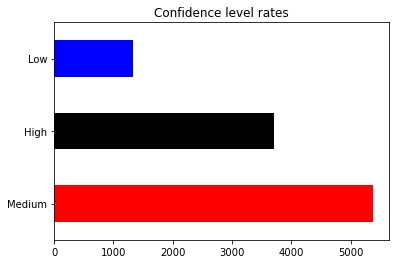

In [28]:
tweets_df['confidence_level'].value_counts().plot(kind = 'barh', color = ['red', 'black', 'blue'])
plt.title('Confidence level rates')
plt.show()

In [29]:
print(tweets_df['airline'].unique())
tweets_df['airline'].value_counts()

['Delta' 'United' 'Southwest' 'US Airways' 'Virgin America' 'American']


United            3822
US Airways        2913
American          2604
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [30]:
tweets_df['airline_sentiment_gold'].value_counts()

            14445
negative       32
positive        5
neutral         3
Name: airline_sentiment_gold, dtype: int64

In [31]:
from math import ceil

# Given values
N = 14485  # Population size
Z = 1.96   # Z-score for 95% confidence level
p = 0.5    # Proportion for maximum variability
E = 0.05   # Margin of error (5%)

# Sample size formula with finite population correction
n_0 = (Z**2 * p * (1 - p)) / E**2  # Sample size for infinite population
n = n_0 / (1 + (n_0 - 1) / N)      # Adjusted for finite population

# Ceiling the sample size to the next whole number
n = ceil(n)

n

375

In our Exploratory Data Analysis (EDA), we have excluded the gold standard sample due to its small size (40 data points) and high margins of error for neutral and positive sentiments, which undermine its statistical reliability and representativeness. The gold standard sample, representing only 0.276% of the total dataset, is primarily intended for validation and calibration of sentiment analysis models rather than for broad exploratory purposes. Including it could skew our findings and does not align with the objective of uncovering comprehensive patterns and trends within the entire dataset. Therefore, we focus on the complete dataset to ensure a thorough and unbiased analysis.

In [32]:
tweets_df.drop('airline_sentiment_gold', axis=1, inplace=True) 
if 'airline_sentiment_gold' not in tweets_df.columns:
    print('Column dropped')

Column dropped


In [33]:
print(f"Unique users: {tweets_df['name'].nunique()}") 
print(f"Average number of tweets: {tweets_df['name'].value_counts().mean()}") 

Unique users: 7701
Average number of tweets: 1.8809245552525646


In [34]:
avg_tweets = tweets_df['name'].value_counts().mean()
vocal_users = tweets_df['name'].value_counts().to_frame().head(20).reset_index()
vocal_users.columns = ['user', '#_tweets']
vocal_users['#_tweets'] = round(vocal_users['#_tweets']/avg_tweets,2) 
vocal_users

,user,#_tweets
0,JetBlueNews,33.49
1,kbosspotter,17.01
2,_mhertz,15.42
3,otisday,14.89
4,throthra,14.35
5,rossj987,12.23
6,GREATNESSEOA,11.70
7,weezerandburnie,11.70
8,scoobydoo9749,11.16
9,jasemccarty,10.63


In [35]:
users = tweets_df['name'].value_counts().to_frame().reset_index()
users.columns = ['user', '#_tweets']
users['comparison'] = round(users['#_tweets']/avg_tweets,2) 
bins = [0, 1, 5, 20, float('inf')]
labels = ['Low Activity', 'Moderate Activity', 'High Activity', 'Very High Activity']
users['classification'] = pd.cut(users['comparison'], bins=bins, labels=labels, include_lowest=True)
users.head(10)

,user,#_tweets,comparison,classification
0,JetBlueNews,63,33.49,Very High Activity
1,kbosspotter,32,17.01,High Activity
2,_mhertz,29,15.42,High Activity
3,otisday,28,14.89,High Activity
4,throthra,27,14.35,High Activity
5,rossj987,23,12.23,High Activity
6,GREATNESSEOA,22,11.70,High Activity
7,weezerandburnie,22,11.70,High Activity
8,scoobydoo9749,21,11.16,High Activity
9,jasemccarty,20,10.63,High Activity


In [36]:
users['classification'].value_counts()

Low Activity          4752
Moderate Activity     2874
High Activity           74
Very High Activity       1
Name: classification, dtype: int64

In [37]:
classification_dict = users.set_index('user')['classification'].to_dict()
tweets_df['user_activity'] = tweets_df['name'].map(classification_dict)
tweets_df[['name','user_activity']] 

,name,user_activity
0,JetBlueNews,Very High Activity
1,nesi_1992,Low Activity
2,CPoutloud,Low Activity
3,brenduch,Moderate Activity
4,VahidESQ,Moderate Activity
...,...,...
14480,Oneladyyouadore,Moderate Activity
14481,DebbiMcGinnis,Low Activity
14482,jaxbra,Low Activity
14483,GAKotsch,Moderate Activity


In [38]:
jet_blue = tweets_df[tweets_df['name']=='JetBlueNews']
jet_blue['airline_sentiment'].value_counts()

neutral     57
positive     5
negative     1
Name: airline_sentiment, dtype: int64

In [39]:
jet_blue_tweets = jet_blue.index.to_list()
tweets_df.drop(jet_blue_tweets, inplace=True)
tweets_df.reset_index(drop=True)
print(f"New # of users: {tweets_df.shape[0]}")
print('\n')
if tweets_df.shape[0] + len(jet_blue_tweets) == 14485:
    print('JetBlueNews dropped successfully')
else:
    print('Review your code')
tweets_df.head(10)

New # of users: 14422


JetBlueNews dropped successfully


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,negativereason_gold,retweet_count,text,tweet_created,tweet_location,confidence_level,user_activity
1,567590027375702016,negative,1.0000,Can't Tell,0.6503,Delta,nesi_1992,,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,2015-02-16 23:43:02 -0800,undecided,Medium,Low Activity
2,567591480085463040,negative,1.0000,Late Flight,0.3460,United,CPoutloud,,0,@united yes. We waited in line for almost an h...,2015-02-16 23:48:48 -0800,"Washington, DC",Medium,Low Activity
3,567592368451248130,negative,1.0000,Late Flight,1.0000,United,brenduch,,0,@united the we got into the gate at IAH on tim...,2015-02-16 23:52:20 -0800,Unknown,High,Moderate Activity
4,567594449874587648,negative,1.0000,Customer Service Issue,0.3451,Southwest,VahidESQ,,0,@SouthwestAir its cool that my bags take a bit...,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Medium,Moderate Activity
5,567594579310825473,negative,1.0000,Bad Flight,0.6707,United,brenduch,,0,@united and don't hope for me having a nicer f...,2015-02-17 00:01:07 -0800,Unknown,Medium,Moderate Activity
6,567595670463205376,negative,1.0000,Late Flight,1.0000,United,CRomerDome,,0,@united I like delays less than you because I'...,2015-02-17 00:05:27 -0800,"Portland, OR",High,Low Activity
7,567614049425555457,negative,1.0000,Customer Service Issue,0.3545,United,JustOGG,,0,"@united, link to current status of flights/air...",2015-02-17 01:18:29 -0800,Unknown,Medium,Moderate Activity
8,567617081336950784,negative,1.0000,Customer Service Issue,1.0000,Southwest,mrshossruns,,0,@SouthwestAir you guys there? Are we on hour 2...,2015-02-17 01:30:32 -0800,Unknown,High,Moderate Activity
9,567617486703853568,negative,1.0000,Customer Service Issue,0.6797,United,feliciastoler,,0,@united I tried 2 DM it would not go thru... n...,2015-02-17 01:32:09 -0800,New Jersey,Medium,Low Activity
10,567623209026334720,negative,0.6337,Flight Booking Problems,0.6337,United,markhlyon,,0,"Wanted to get my bag benefit, but instead get ...",2015-02-17 01:54:53 -0800,"Washington, DC",Medium,Low Activity


In [40]:
tweets_df['user_activity'].value_counts()

Moderate Activity    8615
Low Activity         4752
High Activity        1055
Name: user_activity, dtype: int64

In [41]:
tweets_df['negativereason_gold'].value_counts()

                                            14390
Customer Service Issue                         12
Late Flight                                     4
Can't Tell                                      3
Cancelled Flight                                3
Cancelled Flight\nCustomer Service Issue        2
Late Flight\nFlight Attendant Complaints        1
Customer Service Issue\nLost Luggage            1
Late Flight\nLost Luggage                       1
Bad Flight                                      1
Lost Luggage\nDamaged Luggage                   1
Customer Service Issue\nCan't Tell              1
Flight Attendant Complaints                     1
Late Flight\nCancelled Flight                   1
Name: negativereason_gold, dtype: int64

In [42]:
tweets_df.drop('negativereason_gold', axis=1, inplace=True)
if 'negativereason_gold'not in tweets_df.columns:
    print('Column dropped')

Column dropped


In [43]:
tweets_df[['tweet_id','airline_sentiment','retweet_count','tweet_location']].sort_values(by='retweet_count', ascending=False)

,tweet_id,airline_sentiment,retweet_count,tweet_location
1290,567897883875217408,negative,44,Unknown
1338,567909106553483264,negative,32,Unknown
11441,569927288751587328,negative,31,"New York City, NY"
8033,569584057270575105,neutral,28,Airports Around The World
11507,569932678688055296,negative,22,"Raleigh, NC"
...,...,...,...,...
4963,568884344221081600,negative,0,Edinbrah
4964,568884379600224258,neutral,0,"San Francisco, CA"
4967,568884675021635584,negative,0,"Scottsdale, AZ"
4968,568884731489562624,neutral,0,Hogwarts


In [44]:
tweets_df['tweet_created'].nunique()

14184

In [45]:
print(f"Previous data type: {tweets_df['tweet_created'].dtype}") 
tweets_df['tweet_created'] = pd.to_datetime(tweets_df['tweet_created'], errors='coerce').dt.tz_localize(None)
print(f"Current data type: {tweets_df['tweet_created'].dtype}") 

Previous data type: object
Current data type: datetime64[ns]


In [46]:
tweets_df['early_morning_tweet'] = 0
tweets_df['morning_tweet'] = 0
tweets_df['afternoon_tweet'] = 0
tweets_df['night_tweet'] = 0
tweets_df['late_night_tweet'] = 0

# Function to assign values based on the hour of tweet creation
def assign_time_periods(hour):
    if 5 <= hour <= 8:
        return 1, 0, 0, 0, 0
    elif 9 <= hour <= 11:
        return 0, 1, 0, 0, 0
    elif 12 <= hour <= 17:
        return 0, 0, 1, 0, 0
    elif 18 <= hour <= 21:
        return 0, 0, 0, 1, 0
    else:
        return 0, 0, 0, 0, 1

# Apply the function to each tweet's creation hour
tweets_df[['early_morning_tweet', 'morning_tweet', 'afternoon_tweet', 'night_tweet', 'late_night_tweet']] = tweets_df['tweet_created'].apply(
    lambda x: pd.Series(assign_time_periods(x.hour))
)

In [47]:
tweets_df[['early_morning_tweet', 'morning_tweet', 'afternoon_tweet', 'night_tweet', 'late_night_tweet']].sum()

early_morning_tweet    2789
morning_tweet          2808
afternoon_tweet        4901
night_tweet            2450
late_night_tweet       1474
dtype: int64

In [48]:
week_dict = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
tweets_df['day_of_week'] = tweets_df['tweet_created'].dt.dayofweek
tweets_df['day_of_week'] = tweets_df['day_of_week'].map(week_dict)
print(*[i for i in tweets_df['day_of_week'].unique()])
tweets_df['day_of_week'].value_counts()

Monday Tuesday Wednesday Thursday Friday Saturday Sunday


Sunday       3073
Monday       3029
Tuesday      2589
Saturday     1551
Friday       1489
Thursday     1366
Wednesday    1325
Name: day_of_week, dtype: int64

In [49]:
tweets_df.dtypes

tweet_id                                 int64
airline_sentiment                       object
airline_sentiment_confidence           float64
negativereason                          object
negativereason_confidence              float32
airline                                 object
name                                    object
retweet_count                            int64
text                                    object
tweet_created                   datetime64[ns]
tweet_location                          object
confidence_level                      category
user_activity                           object
early_morning_tweet                      int64
morning_tweet                            int64
afternoon_tweet                          int64
night_tweet                              int64
late_night_tweet                         int64
day_of_week                             object
dtype: object

I have decided to exclude the `airline_sentiment_confidence` and `negativereason_confidence columns`. While these columns are useful for validating the accuracy of sentiment classifications, they are not necessary for the purposes of the dashboard I am creating, which aims to present clear and actionable insights to stakeholders.

**Reasons for Exclusion:**
- **Assumption of Data Validation:**

    I am assuming that the dataset has been pre-validated, meaning that the sentiment and negative reason classifications are accurate and reliable. Therefore, including confidence scores adds little value to the overall analysis and may unnecessarily complicate the dashboard.


- **Focus on Findings:**

    Stakeholders are primarily interested in the findings and insights derived from the data rather than the underlying confidence levels of each classification. By excluding these columns, I can focus more directly on uncovering patterns, trends, and actionable insights without the distraction of confidence metrics.


- **Simplicity and Clarity:**

    Simplifying the dataset by removing the confidence columns helps streamline the dashboard design, making it more accessible and easier to interpret for stakeholders. This enhances the clarity of the visualizations and ensures that the key messages are communicated effectively.


- **Alignment with Objective:**

    The objective of the dashboard is to provide a comprehensive analysis of the sentiment data. Including confidence scores, which are primarily useful for model validation, does not align with this objective. Instead, I focus on the sentiments and reasons themselves to uncover meaningful trends within the dataset.

By focusing on the core sentiment data and excluding the confidence scores, I ensure that the dashboard remains focused, clear, and aligned with the needs of my stakeholders.

In [50]:
tweets_df.drop(['airline_sentiment_confidence', 'negativereason_confidence'], axis=1, inplace=True) 
if 'airline_sentiment_confidence' and 'negativereason_confidence' not in tweets_df.columns:
    print('Columns dropped')
else: 
    print('Columns NOT dropeed')

Columns dropped


In [51]:
for i in tweets_df.columns:
    print(i)

tweet_id
airline_sentiment
negativereason
airline
name
retweet_count
text
tweet_created
tweet_location
confidence_level
user_activity
early_morning_tweet
morning_tweet
afternoon_tweet
night_tweet
late_night_tweet
day_of_week


In [52]:
tweets_df.to_csv('final_airline_data_set.csv', index=False)

In [53]:
tweets_df['airline'].unique()

array(['Delta', 'United', 'Southwest', 'US Airways', 'Virgin America',
       'American'], dtype=object)